In [3]:
%matplotlib inline
import osmnx as ox
import networkx as nx
import csv
import time
import numpy as np
import scipy.sparse as sp
import scipy.io
from pyproj import Proj
import matplotlib.pyplot as plt

# Data Processing

In [ ]:
def findParams(n, f):
  morn_counts = np.zeros(n)
  eve_counts = np.zeros(n)

  # Weekdays:
  # Morning: 6-10AM
  # Evening: 4-8PM
  morn_coords = ([], [])
  eve_coords = ([], [])

  with open(f) as csvfile:
    reader = csv.reader(csvfile)
    for r in reader:
      t = time.localtime(int(r[1]))
      if t.tm_wday >= 5: continue
      i = int(r[3])
      if t.tm_hour > 6 and t.tm_hour < 10:
        morn_counts[i-1] += 1
        morn_coords[0].append(i-1)
        morn_coords[1].append(int(r[4]) -1)
      elif t.tm_hour > 16 and t.tm_hour < 20:
        eve_counts[i-1] += 1
        eve_coords[0].append(i-1)
        eve_coords[1].append(int(r[4]) - 1)      

  mornM = sp.csc_matrix((np.ones(len(morn_coords[0])), morn_coords), (n,n)) / (morn_counts[:,None] + 1)
  eveM = sp.csc_matrix((np.ones(len(eve_coords[0])), eve_coords), (n,n)) / (eve_counts[:,None] + 1)

  mornP = morn_counts / 1440
  eveP = eve_counts / 1440

# Chicago

In [ ]:
g = ox.graph_from_place("Chicago", network_type="drive").to_directed()
bc = None
for c in nx.strongly_connected_component_subgraphs(g):
  if bc is None or c.number_of_nodes() > bc.number_of_nodes():
    bc = c
chicago = ox.project_graph(nx.convert_node_labels_to_integers(bc))
# ah, we can't do this. the data has already been matched here. 
nx.write_edgelist(g, "chicago.csv", delimiter=",", data=False)

# Manhattan

In [17]:
g = ox.graph_from_place("Manhattan", network_type="drive").to_directed()
bc = None
for c in nx.strongly_connected_component_subgraphs(g):
  if bc is None or c.number_of_nodes() > bc.number_of_nodes():
    bc = c
g = ox.project_graph(nx.convert_node_labels_to_integers(bc))
g = nx.DiGraph(g)

In [ ]:
# Question: does to_directed() do the right thing and break undirected edges into two directed ones?
# or does it pick an arbitrary direction?
# Also: when we take a MultiGraph to a DiGraph, which of the edges do we pick?
# We really want to pick the one that takes the shortest amount of time to traverse. 

In [24]:
nx.write_edgelist(g, "manhattan.csv", delimiter=",", data=["length", "maxspeed"])

In [ ]:
!sed -i'' 's/ mph//g' manhattan.csv

In [3]:
proj = Proj(g.graph['crs'])

In [4]:
with open("manhattan-coords.csv", "w") as csvfile:
    writer = csv.writer(csvfile)
    for n in g.nodes():
      nd = g.node[n]
      writer.writerow([nd['x'], nd['y']])

In [ ]:
# length is by default in 'meters'
# maxpseed is by default in 'miles per hour'
# Ugh. 

In [27]:
g[0][2]

{'osmid': 165775306,
 'oneway': True,
 'name': 'Chatham Square',
 'highway': 'primary',
 'maxspeed': '25 mph',
 'length': 51.557,
 'geometry': <shapely.geometry.linestring.LineString at 0x7f4f10084780>}

In [ ]:
# We also have to assume that missing maxspeed fields are 30

In [ ]:
# How will we do the line graph thing?

## Kevin taxi data

In [5]:
lons = []
lats = []
with open('kevin-taxi/intersections.csv') as csvfile:
  reader = csv.reader(csvfile)
  for r in reader:
    lons.append(float(r[1]))
    lats.append(float(r[2]))
xs, ys = proj(np.array(lons), np.array(lats))

20 blocks is about a mile in NYC. So (1/20 of a mile) is one street. Say cars are going 25 mph

(20 streets/ 1 mile) \* (25 mile / 1 hour) = (25 \* 20 streets / hour)
1 street = (3600 / (25 \* 20)) seconds = 7.2 seconds. Let's round to 10. This means 100 blocks takes 10 minutes. But you cannot REALLY get from Houston to harlem in 10 minutes taking surface streets. We aren't factoring in red lights. Whatever. Good enough

In [ ]:
# what if we want to simulate a run using this data? 
# We might need to do this in julia. 
# ah, but the thing is, the intersections in kevin's files
# aren't necessarily the same intersections that osmnx sees
# we'd like to write a matrix of trips
# one row per trip
# startime, osmnx id start, osmnx id end
# DO THIS!
# can store these as morning and evening trip matrices
# then we can see how well we do training
# on morning, testing on evening. 

# other idea: save the last day in the taxiweek JUST for testing
# This lets us validate, ensure we're not overfitting. 
# we should have three functions: one for morning, one for
# evening, one for the whole day. Ideally we'd like to see 
# how statistics change over the course of the day.
# But that's getting complicated

In [18]:
# Let's make a count vector, one bucket per intersection per time period. 
# Then we divide by the time period. Check probabilities, inflate slightly. 
n = len(lons)
morn_counts = np.zeros(n)
eve_counts = np.zeros(n)

# Weekdays:
# Morning: 6-10AM
# Evening: 4-8PM
morn_coords = ([], [])
eve_coords = ([], [])

with open('kevin-taxi/taxiweek.csv') as csvfile:
  reader = csv.reader(csvfile)
  for r in reader:
    t = time.localtime(int(r[1]))
    if t.tm_wday >= 5: continue
    i = int(r[3])
    if t.tm_hour > 6 and t.tm_hour < 10:
      morn_counts[i-1] += 1
      morn_coords[0].append(i-1)
      morn_coords[1].append(int(r[4]) -1)
    elif t.tm_hour > 16 and t.tm_hour < 20:
      eve_counts[i-1] += 1
      eve_coords[0].append(i-1)
      eve_coords[1].append(int(r[4]) - 1)      

mornM = sp.csc_matrix((np.ones(len(morn_coords[0])), morn_coords), (n,n)) / (morn_counts[:,None] + 1)
eveM = sp.csc_matrix((np.ones(len(eve_coords[0])), eve_coords), (n,n)) / (eve_counts[:,None] + 1)

mornP = morn_counts / 1440
eveP = eve_counts / 1440

Both zones are 4 hours long. There are 1440 10 second intervals are in 4 hours.

In [7]:
locs = ox.get_nearest_nodes(g, xs, ys, 'kdtree')

In [8]:
trueN = g.number_of_nodes()
permI = []
permJ = []
for i,j in enumerate(locs):
  permI.append(j)
  permJ.append(i)
P = sp.csc_matrix((np.ones(len(permI)), (permI, permJ)), (trueN, n))

In [19]:
mornP = (P @ mornP) + 1e-8
eveP = (P @ eveP) + 1e-8
mornM = (P @ mornM @ P.T) + 1e-9
eveM = (P @ eveM @ P.T) + 1e-9

In [10]:
locs

array([ 914, 4005,  186, ..., 1091, 4367,  524])

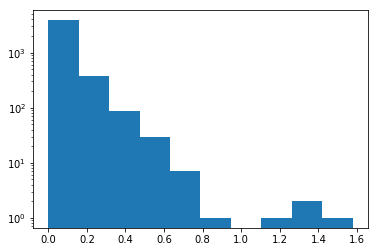

In [11]:
plt.hist(mornP, log=True);

In [20]:
scipy.io.savemat("kevin-data", {'mornM': mornM, 'eveM': eveM, 'mornP': mornP, 'eveP': eveP}, do_compression=True, oned_as='column')

### Permutation example

In [76]:
P = sp.csc_matrix((np.ones(2), ([5,7], [0,1])), (8, 2))

In [79]:
M = sp.csc_matrix((np.ones(1), ([0], [1])), (2, 2))

In [82]:
(P @ M @ P.T).toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])